In [6]:
!pip install dice-ml

In [7]:
pip install pgmpy

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.ensemble import IsolationForest
from scipy import stats
import dice_ml
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.utils import get_example_model
from graphviz import Digraph

In [9]:
file = pd.read_csv('/content/Bank_Personal_Loan_Modelling.csv')

In [10]:
#annamoly detections
def anomaly_detection(df, *args):
  model_IF = IsolationForest().fit(df[list(args)])
  df['IF_anomaly'] = model_IF.predict(df[list(args)])
  anomaly_free_df = df[df['IF_anomaly'] != -1].copy()
  anomaly_free_df.drop(columns=['IF_anomaly'], inplace=True)
  return anomaly_free_df


cl_fl = anomaly_detection(file, 'Income', 'CCAvg',
        'Mortgage')



def preprocess_data(df):
    continuous_columns = []
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            continuous_columns.append(column)

    for col in df.columns:
        if col not in continuous_columns:
            unique = df[col].unique()
            for i in unique:
                new_col_name = f"{col}_{i}"
                df[new_col_name] = (df[col] == i).astype(int)
            del df[col]

    return df

In [11]:
cl_fl = preprocess_data(cl_fl)
cl_fl

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [12]:
cl_fl = cl_fl.drop(columns=['ID','ZIP Code'])


# DAGs : Identifying Confounders

  0%|          | 0/1000000 [00:00<?, ?it/s]

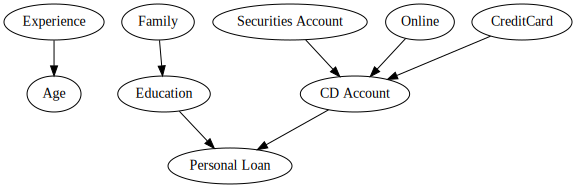

In [13]:
hc = HillClimbSearch(cl_fl)
best_model = hc.estimate(scoring_method=BicScore(cl_fl))
edges_list = list(best_model.edges())
first_edge = edges_list
updated_list = [(x, y) if x != 'Personal Loan' else (y, x) for x, y in first_edge]
g = Digraph()
for edge in updated_list:
    g.edge(edge[0], edge[1])
g

# Model Trainign

In [14]:
X = cl_fl.drop(columns='Personal Loan')
y = cl_fl['Personal Loan']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
over_samp = RandomOverSampler()
new_X_train, new_y_train = over_samp.fit_resample(X_train, y_train)

In [28]:
new_X_train

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,57,33,24,4,0.70,1,0,0,0,1,0
1,42,18,54,1,1.80,1,0,0,0,1,0
2,63,37,45,2,1.00,3,88,0,0,1,1
3,42,17,60,1,2.40,1,98,0,0,1,0
4,33,9,61,3,2.60,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5859,32,8,119,4,5.00,3,0,0,0,1,0
5860,56,32,103,3,4.00,3,0,0,0,0,0
5861,56,32,158,3,3.70,3,0,0,0,1,0
5862,44,17,128,2,3.25,2,0,0,0,0,1


In [17]:
def mask_input(X, num_features, variable_to_mask):
    mask = tf.concat([
        tf.ones((tf.shape(X)[0], variable_to_mask)),
        tf.zeros((tf.shape(X)[0], 1)),
        tf.ones((tf.shape(X)[0], num_features - variable_to_mask - 1))
    ], axis=1)
    return tf.multiply(X, mask)

def feedforward_nn(input_shape, num_features, variable_to_mask):
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: mask_input(x, num_features, variable_to_mask), input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(9, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [29]:
num_features = X_train.shape[1]
variable_to_mask_index = 8

In [30]:
mdl = feedforward_nn(input_shape=(num_features,), num_features=num_features, variable_to_mask=variable_to_mask_index)

In [31]:
mdl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
            loss='binary_crossentropy',
            metrics=['accuracy'])
mdl.fit(new_X_train, new_y_train, epochs=15, batch_size=32)

Epoch 1/15
184/184 [==============================] - 5s 10ms/step - loss: 0.4676 - accuracy: 0.8191
Epoch 2/15
184/184 [==============================] - 2s 11ms/step - loss: 0.3546 - accuracy: 0.8651
Epoch 3/15
184/184 [==============================] - 1s 7ms/step - loss: 0.3198 - accuracy: 0.8776
Epoch 4/15
184/184 [==============================] - 1s 5ms/step - loss: 0.3079 - accuracy: 0.8871
Epoch 5/15
184/184 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.8902
Epoch 6/15
184/184 [==============================] - 1s 5ms/step - loss: 0.2973 - accuracy: 0.8866
Epoch 7/15
184/184 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8917
Epoch 8/15
184/184 [==============================] - 1s 3ms/step - loss: 0.3013 - accuracy: 0.8835
Epoch 9/15
184/184 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8876
Epoch 10/15
184/184 [==============================] - 0s 2ms/step - loss: 0.2989 - accuracy: 0.88

In [32]:
train_acc = mdl.evaluate(new_X_train, new_y_train)[1]
test_acc = mdl.evaluate(X_test, y_test)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

24/24 [==============================] - 0s 5ms/step - loss: 0.2349 - accuracy: 0.8940
Training accuracy: 0.9082537293434143
Testing accuracy: 0.8939790725708008


# Dice

In [33]:
dic_model = dice_ml.Model(model=mdl)

In [34]:
d = dice_ml.Data(dataframe=cl_fl,
                 continuous_features=['Age', 'Experience','Income','CCAvg'],
                 outcome_name='Personal Loan')

In [35]:
tr = dice_ml.Dice(d,dic_model)

In [43]:
query_instance = new_X_train[3:5]

In [44]:
dice_exp = tr.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


In [45]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,42,17,60,1,2.4,1,98,0,0,1,0,0



Diverse Counterfactual set (new outcome: 1)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,35.0,-,156.0,-,-,-,0.0,-,-,-,-,1.0
1,-,24.0,-,-,4.3,-,0.0,1.0,-,-,-,1.0
2,35.0,-,156.0,-,2.1,-,0.0,-,-,-,-,1.0
3,-,39.0,-,-,-,2.0,0.0,-,-,0.0,-,1.0


Query instance (original outcome : 0)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,33,9,61,3,2.6,2,0,0,0,1,0,0



Diverse Counterfactual set (new outcome: 1)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,-,-,80.0,-,-,-,-,1.0,-,-,-,1.0
1,-,-,113.0,-,0.3,-,-,-,-,-,-,1.0
2,-,-,-,-,5.1,-,-,-,-,-,-,1.0
3,-,-,154.0,-,-,-,-,-,-,-,-,1.0
